# Import(s)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from functools import lru_cache # For caching DTW results

from dtaidistance import dtw

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans # Using MiniBatchKMeans for speed on large embedding sets
import matplotlib.pyplot as plt
import os 

# Config

In [ ]:
SYMBOL = 'BTCUSDT'
WINDOW_SIZE = 20  # Input dimension for VAE
LATENT_DIM = 5    # Desired embedding dimension
STRIDE = 5        # Stride used when generating subsequences (for filenames)

# Training Hyperparameters
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-3
BETA_KLD = 1.0
GAMMA_DTW_TRIPLET = 0.1
MARGIN = 1.0
PRINT_EVERY = 1000 
# GAMMA_EUCLIDEAN_TRIPLET = 0.0 # Weight for Euclidean-based triplet loss on latent space. Start with 0.

# Early Stopping
PATIENCE = 5      
MIN_DELTA = 1e-5  # Minimum change to qualify as an improvement

# Paths
DATA_DIR = 'data'
SUBSEQUENCE_DIR = os.path.join(DATA_DIR, 'subsequences')
EMBEDDING_DIR = os.path.join(DATA_DIR, 'embeddings')
MODEL_DIR = os.path.join(DATA_DIR, 'autoencoder_models')

# Create directories if they don't exist
os.makedirs(SUBSEQUENCE_DIR, exist_ok=True)
os.makedirs(EMBEDDING_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# File names
subsequence_filename = f'subseq_{SYMBOL}_ws={WINDOW_SIZE}_stride={STRIDE}.csv'
subsequence_filepath = os.path.join(SUBSEQUENCE_DIR, subsequence_filename)

best_model_path = os.path.join(MODEL_DIR, f'best_vae_dtw_shape_{SYMBOL}_ws{WINDOW_SIZE}_ld{LATENT_DIM}.pt')
final_embeddings_path = os.path.join(EMBEDDING_DIR, f'embed_vae_dtw_shape_{SYMBOL}_ws{WINDOW_SIZE}_ld{LATENT_DIM}.csv')

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Load Original Subsequences & Build Indexed Dataset

In [ ]:
print(f"Loading subsequences from: {subsequence_filepath}")
if not os.path.exists(subsequence_filepath):
    print(f"ERROR: Subsequence file not found at {subsequence_filepath}")
    print("Please ensure your 'data_processing.ipynb' (or equivalent) has been run to generate this file.")

subseq_df = pd.read_csv(subsequence_filepath)
data_np = subseq_df.values.astype(np.float32) # 20-dimensional original subsequences

# Create global indices for each subsequence
indices_np = np.arange(len(data_np), dtype=np.int64)

# TensorDataset:
# - First tensor:  the actual subsequence data 
# - Second tensor: the global index of each subsequence (for DTW caching)
dataset = TensorDataset(
    torch.from_numpy(data_np),      
    torch.from_numpy(indices_np) 
)
print(f"Successfully loaded {len(dataset)} subsequences, each of length {data_np.shape[1]}.")

Loading subsequences from: data/subsequences/subseq_BTCUSDT_ws=20_stride=5.csv
Successfully loaded 759789 subsequences, each of length 20.


## Train/Validation Split

In [7]:
val_frac = 0.2
n_total = len(dataset)
n_val = int(n_total * val_frac)
n_train = n_total - n_val

train_ds, val_ds = random_split(dataset, [n_train, n_val])
print(f"Training dataset size:  \t{len(train_ds)}")
print(f"Validation dataset size:\t{len(val_ds)}")

Training dataset size:  	607832
Validation dataset size:	151957


## DataLoaders

In [ ]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"Train loader:      {len(train_loader)} batches of size {BATCH_SIZE} (with drop_last=True)")
print(f"Validation loader: {len(val_loader)} batches of size {BATCH_SIZE} (with drop_last=False)")

Train loader:      9497 batches of size 64 (with drop_last=True)
Validation loader: 2375 batches of size 64 (with drop_last=False)


In [ ]:
# Test one batch from train_loader
try:
    sample_batch_data, sample_batch_indices = next(iter(train_loader))
    print(f"Sample batch data shape:    {sample_batch_data.shape}")     
    print(f"Sample batch indices shape: {sample_batch_indices.shape}") 
    print(f"Sample indices:             {sample_batch_indices[:5]}") 
except StopIteration:
    print("ERROR: DataLoader is empty.")


Sample batch data shape:    torch.Size([64, 20])
Sample batch indices shape: torch.Size([64])
Sample indices:             tensor([587967, 441696, 705267, 162173, 590297])


# Define VAE Model

In [ ]:
class VAE_DTW(nn.Module):
    def __init__(self, input_dim=WINDOW_SIZE, hidden_dim1=64, hidden_dim2=32, latent_dim=LATENT_DIM): # Made it a bit deeper
        super(VAE_DTW, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.enc_fc1 = nn.Linear(input_dim, hidden_dim1)
        self.enc_fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.enc_fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.enc_fc_log_var = nn.Linear(hidden_dim2, latent_dim)

        # Decoder
        self.dec_fc1 = nn.Linear(latent_dim, hidden_dim2)
        self.dec_fc2 = nn.Linear(hidden_dim2, hidden_dim1)
        self.dec_fc3 = nn.Linear(hidden_dim1, input_dim)
        
        print(f"VAE_DTW Model Initialized: InputDim={input_dim}, LatentDim={latent_dim}, Hidden1={hidden_dim1}, Hidden2={hidden_dim2}")


    def encode(self, x):
        h1 = F.relu(self.enc_fc1(x))
        h2 = F.relu(self.enc_fc2(h1))
        return self.enc_fc_mu(h2), self.enc_fc_log_var(h2)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(device) 
        return mu + eps * std

    def decode(self, z):
        h1 = F.relu(self.dec_fc1(z))
        h2 = F.relu(self.dec_fc2(h1))
        return self.dec_fc3(h2) 

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, self.input_dim))
        z_sampled = self.reparameterize(mu, log_var) # Sampled latent point for reconstruction
        reconstruction = self.decode(z_sampled)
        # Use mu (the mean of the distribution) as the representative embedding for triplet loss
        return reconstruction, mu, log_var, mu

## DTW Cache & Triplet Mining

In [ ]:
# Global cache for DTW distances.
# data_np is the numpy array of original subsequences.

if 'data_np' not in globals():
    print("Reloading data_np for DTW cache...")
    if not os.path.exists(subsequence_filepath):
        raise FileNotFoundError(f"Subsequence file not found: {subsequence_filepath}.")
    _subseq_df_temp = pd.read_csv(subsequence_filepath)
    data_np = _subseq_df_temp.values.astype(np.float32)
    print("data_np reloaded.")

In [ ]:
@lru_cache(maxsize=200000)
def dtw_distance_cached(global_idx1, global_idx2):
    """
    Computes DTW distance between two globally indexed subsequences, using a cache.
    Ensures indices are ordered to maximize cache hits for symmetric calls.
    """
    idx1, idx2 = min(global_idx1, global_idx2), max(global_idx1, global_idx2)

    seq1 = np.ascontiguousarray(data_np[idx1], dtype=np.double)
    seq2 = np.ascontiguousarray(data_np[idx2], dtype=np.double)
    
    distance = dtw.distance_fast(seq1, seq2, use_pruning=True)
    return distance

In [ ]:
def mine_dtw_triplets_from_batch_indices(batch_global_indices_np, # numpy array of global indices
                                         latent_embeddings_batch, # Pytorch tensor of latent embeddings (mu) for this batch
                                         k_positive=1,
                                         k_negative=1):
    """
    Mines triplets based on DTW distances of original subsequences for the current batch.
    Args:
        batch_global_indices_np: NumPy array of global indices for the current batch.
        latent_embeddings_batch: PyTorch tensor of latent embeddings (e.g., mu) for the current batch.
        k_positive:              How many of the closest  DTW neighbors to consider as positives.
        k_negative:              How many of the furthest DTW neighbors to consider as negatives.
    Returns:
        Tuple of (anchor_latents, positive_latents, negative_latents) as PyTorch tensors.
    """
    current_batch_size = len(batch_global_indices_np)
    if current_batch_size < 3:
        return None, None, None

    anchors_latent_list = []
    positives_latent_list = []
    negatives_latent_list = []

    for local_anchor_idx in range(current_batch_size):
        global_anchor_idx = batch_global_indices_np[local_anchor_idx]
        
        dtw_distances_to_anchor = []
        for local_other_idx in range(current_batch_size):
            if local_anchor_idx == local_other_idx:
                continue
            global_other_idx = batch_global_indices_np[local_other_idx]
            dist = dtw_distance_cached(global_anchor_idx, global_other_idx)
            dtw_distances_to_anchor.append({'distance': dist, 'local_idx': local_other_idx})

        if not dtw_distances_to_anchor:
            continue

        # Sort by DTW distance
        dtw_distances_to_anchor.sort(key=lambda x: x['distance'])

        # Select positives
        current_positives_local_indices = []
        for i in range(min(k_positive, len(dtw_distances_to_anchor))):
            current_positives_local_indices.append(dtw_distances_to_anchor[i]['local_idx'])

        # Select negatives
        current_negatives_local_indices = []
        for i in range(min(k_negative, len(dtw_distances_to_anchor))):
            current_negatives_local_indices.append(dtw_distances_to_anchor[-(i+1)]['local_idx'])
        
        # Create triplets
        anchor_latent_embedding = latent_embeddings_batch[local_anchor_idx]
        for local_pos_idx in current_positives_local_indices:
            for local_neg_idx in current_negatives_local_indices:
                if local_pos_idx != local_neg_idx: # Ensure positive and negative are different
                    anchors_latent_list.append(anchor_latent_embedding)
                    positives_latent_list.append(latent_embeddings_batch[local_pos_idx])
                    negatives_latent_list.append(latent_embeddings_batch[local_neg_idx])

    if not anchors_latent_list:
        return None, None, None

    return torch.stack(anchors_latent_list), torch.stack(positives_latent_list), torch.stack(negatives_latent_list)

In [ ]:
print("VAE_DTW class and DTW utility functions defined.")

if 'data_np' in globals() and len(data_np) > 1:
    dist_test = dtw_distance_cached(0, 1)
    print(f"Test DTW distance between subsequence 0 and 1:          {dist_test}")
    dist_test_cached = dtw_distance_cached(0, 1)
    print(f"Test DTW distance (cached) between subsequence 0 and 1: {dist_test_cached}")
    dist_test_rev = dtw_distance_cached(1,0)
    print(f"Test DTW distance (cached) between subsequence 1 and 0: {dist_test_rev}")


else:
    print("Skipping dtw_cache test as data_np is not loaded or has too few samples.")

VAE_DTW class and DTW utility functions defined.
Test DTW distance between subsequence 0 and 1:          0.00730533242015081
Test DTW distance (cached) between subsequence 0 and 1: 0.00730533242015081
Test DTW distance (cached) between subsequence 1 and 0: 0.00730533242015081


# Initialize Model, Define Combined Loss, and Optimizer

In [15]:
model = VAE_DTW(input_dim=WINDOW_SIZE, latent_dim=LATENT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# For tracking best model
best_val_loss = float('inf')
epochs_no_improve = 0

print("Model and optimizer initialized.")
print(model)

VAE_DTW Model Initialized: InputDim=20, LatentDim=5, Hidden1=64, Hidden2=32
Model and optimizer initialized.
VAE_DTW(
  (enc_fc1): Linear(in_features=20, out_features=64, bias=True)
  (enc_fc2): Linear(in_features=64, out_features=32, bias=True)
  (enc_fc_mu): Linear(in_features=32, out_features=5, bias=True)
  (enc_fc_log_var): Linear(in_features=32, out_features=5, bias=True)
  (dec_fc1): Linear(in_features=5, out_features=32, bias=True)
  (dec_fc2): Linear(in_features=32, out_features=64, bias=True)
  (dec_fc3): Linear(in_features=64, out_features=20, bias=True)
)


In [ ]:
def calculate_combined_loss(original_sequences,      # Batch of original 20-dim sequences
                            batch_global_indices_np, # NumPy array of global indices for the batch
                            reconstructed_sequences,
                            mu,
                            log_var,
                            latent_embeddings, # These are the 'mu' vectors from VAE forward pass
                            epoch, # Current epoch, for potential annealing or conditional logic
                            dtw_triplet_k_positive=1,
                            dtw_triplet_k_negative=1):
    """
    Calculates the combined VAE loss (Reconstruction + KLD) and
    the DTW-guided triplet loss.
    """
    # VAE Reconstruction Loss (per sample)
    recon_loss = F.mse_loss(reconstructed_sequences, original_sequences, reduction='mean')

    # VAE KL Divergence Loss (per sample): sum over latent dimensions, then mean over batch dimension
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()

    # DTW-Based Triplet Loss (per triplet found)
    dtw_triplet_loss_value = torch.tensor(0.0).to(device)
    num_valid_triplets = 0

    if GAMMA_DTW_TRIPLET > 0 : # Only compute if its weight is positive
        # Mine triplets using DTW on original sequences, get corresponding latent embeddings
        anchors_latent, positives_latent, negatives_latent = mine_dtw_triplets_from_batch_indices(
            batch_global_indices_np,
            latent_embeddings, 
            k_positive=dtw_triplet_k_positive,
            k_negative=dtw_triplet_k_negative
        )

        if anchors_latent is not None and positives_latent is not None and negatives_latent is not None:
            if anchors_latent.shape[0] > 0:
                dtw_triplet_loss_value = F.triplet_margin_loss(
                    anchors_latent,
                    positives_latent,
                    negatives_latent,
                    margin=MARGIN,
                    p=2,
                    reduction='mean'
                )
                num_valid_triplets = anchors_latent.shape[0]
            else:
                dtw_triplet_loss_value = torch.tensor(0.0).to(device)   # No triplets, no loss
        else:
            dtw_triplet_loss_value = torch.tensor(0.0).to(device)       # No triplets, no loss

    GAMMA_EUCLIDEAN_TRIPLET = 0.0 # Explicitly keeping it off for now
    euclidean_triplet_loss_value = torch.tensor(0.0).to(device)


    total_loss = recon_loss + BETA_KLD * kld_loss + \
                 GAMMA_DTW_TRIPLET * dtw_triplet_loss_value + \
                 GAMMA_EUCLIDEAN_TRIPLET * euclidean_triplet_loss_value

    return total_loss, recon_loss, kld_loss, dtw_triplet_loss_value, num_valid_triplets

print("Combined loss function defined.")

Combined loss function defined.


In [17]:
# Test the forward pass of the model with a sample batch
if len(train_ds) >= BATCH_SIZE :
    model.eval() # Set to eval for a test forward pass
    with torch.no_grad():
        sample_data, sample_indices_global = next(iter(train_loader))
        sample_data = sample_data.to(device)
        sample_indices_global_np = sample_indices_global.cpu().numpy()

        recon_test, mu_test, log_var_test, latent_mu_test = model(sample_data)
        print(f"Test forward pass: ")
        print(f"    Input shape:                      {sample_data.shape}")
        print(f"    Reconstruction shape:             {recon_test.shape}")
        print(f"    Mu shape:                         {mu_test.shape}")
        print(f"    LogVar shape:                     {log_var_test.shape}")
        print(f"    Latent (mu for triplet) shape:    {latent_mu_test.shape}")

        # Test combined loss function
        total_loss_test, recon_l, kld_l, dtw_t_l, num_trips = calculate_combined_loss(
            sample_data, sample_indices_global_np, recon_test, mu_test, log_var_test, latent_mu_test, epoch=0
        )
        print(f"Test combined loss: {total_loss_test.item():.4f} (Recon: {recon_l.item():.4f}, KLD: {kld_l.item():.4f}, DTW_Triplet: {dtw_t_l.item():.4f} from {num_trips} triplets)")
else:
    print("Skipping model forward pass and loss test due to insufficient data in train_ds for a full batch.")


Test forward pass: 
    Input shape:                      torch.Size([64, 20])
    Reconstruction shape:             torch.Size([64, 20])
    Mu shape:                         torch.Size([64, 5])
    LogVar shape:                     torch.Size([64, 5])
    Latent (mu for triplet) shape:    torch.Size([64, 5])
Test combined loss: 1.2835 (Recon: 1.1144, KLD: 0.0967, DTW_Triplet: 0.7242 from 64 triplets)


# Training Loop

In [ ]:
print(f"Starting training for {EPOCHS} epochs...")
print(f"Device: {device}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"KLD Beta: {BETA_KLD}")
print(f"DTW Triplet Gamma: {GAMMA_DTW_TRIPLET}")

# For plotting losses later, if needed
history = {
    'train_loss': [], 'val_loss': [],
    'train_recon_loss': [], 'val_recon_loss': [],
    'train_kld_loss': [], 'val_kld_loss': [],
    'train_dtw_triplet_loss': []
}

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_train_loss = 0.0
    epoch_recon_loss = 0.0
    epoch_kld_loss = 0.0
    epoch_dtw_triplet_loss_sum_of_means = 0.0 # Sum of mean triplet losses from batches with triplets
    num_batches_with_triplets_in_epoch = 0

    for batch_idx, (original_input_sequences, batch_global_indices) in enumerate(train_loader):
        original_input_sequences = original_input_sequences.to(device)
        batch_global_indices_np = batch_global_indices.numpy()

        optimizer.zero_grad()
        
        recon_batch, mu, log_var, latent_mu_for_triplet = model(original_input_sequences)

        combined_loss, recon_loss, kld_loss, dtw_triplet_loss, num_valid_trips = calculate_combined_loss(
            original_input_sequences,
            batch_global_indices_np,
            recon_batch,
            mu,
            log_var,
            latent_mu_for_triplet, # mu vectors
            epoch,
            dtw_triplet_k_positive=1,
            dtw_triplet_k_negative=1
        )
        
        if torch.isnan(combined_loss):
            print(f"NaN loss detected at epoch {epoch}, batch {batch_idx}. Stopping.")
            break
            
        combined_loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Aggregate per-sample averaged losses
        epoch_train_loss += combined_loss.item() * original_input_sequences.size(0) 
        epoch_recon_loss += recon_loss.item() * original_input_sequences.size(0)
        epoch_kld_loss += kld_loss.item() * original_input_sequences.size(0)
        
        if num_valid_trips > 0:
            epoch_dtw_triplet_loss_sum_of_means += dtw_triplet_loss.item()
            num_batches_with_triplets_in_epoch += 1
        
        if (batch_idx + 1) % PRINT_EVERY == 0: 
            current_avg_batch_loss = combined_loss.item()
            current_avg_recon_loss = recon_loss.item()
            current_avg_kld_loss = kld_loss.item()
            current_avg_dtw_triplet_loss = dtw_triplet_loss.item() if num_valid_trips > 0 else 0.0
            print(f"  Epoch [{epoch}/{EPOCHS}], Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"AvgBatchLoss: {current_avg_batch_loss:.4f} "
                  f"(R: {current_avg_recon_loss:.4f}, "
                  f"KLD: {current_avg_kld_loss:.4f}, "
                  f"DTW_T: {current_avg_dtw_triplet_loss:.4f} ({num_valid_trips} trips))")

    if torch.isnan(combined_loss):
        break


    # Average losses for the epoch (over all samples)
    avg_epoch_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_epoch_recon_loss = epoch_recon_loss / len(train_loader.dataset)
    avg_epoch_kld_loss = epoch_kld_loss / len(train_loader.dataset)
    avg_epoch_dtw_triplet_loss = (epoch_dtw_triplet_loss_sum_of_means / num_batches_with_triplets_in_epoch) \
                                 if num_batches_with_triplets_in_epoch > 0 else 0.0
    
    history['train_loss'].append(avg_epoch_train_loss)
    history['train_recon_loss'].append(avg_epoch_recon_loss)
    history['train_kld_loss'].append(avg_epoch_kld_loss)
    history['train_dtw_triplet_loss'].append(avg_epoch_dtw_triplet_loss)


    # Validation
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_recon_loss = 0.0
    epoch_val_kld_loss = 0.0
    
    with torch.no_grad():
        for original_input_sequences_val, batch_global_indices_val in val_loader:
            original_input_sequences_val = original_input_sequences_val.to(device)
            batch_global_indices_val_np = batch_global_indices_val.numpy()
            
            recon_batch_val, mu_val, log_var_val, latent_mu_val = model(original_input_sequences_val)
            
            # For validation, I calculate VAE loss components.
            # Set k_positive and k_negative to 0 to skip DTW triplet calculation for speed.
            val_loss_batch, val_recon_l, val_kld_l, _, _ = calculate_combined_loss(
                original_input_sequences_val,
                batch_global_indices_val_np,
                recon_batch_val,
                mu_val,
                log_var_val,
                latent_mu_val,
                epoch,
                dtw_triplet_k_positive=0,
                dtw_triplet_k_negative=0
            )
            
            epoch_val_loss += val_loss_batch.item() * original_input_sequences_val.size(0)
            epoch_val_recon_loss += val_recon_l.item() * original_input_sequences_val.size(0)
            epoch_val_kld_loss += val_kld_l.item() * original_input_sequences_val.size(0)

    avg_epoch_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_epoch_val_recon_loss = epoch_val_recon_loss / len(val_loader.dataset)
    avg_epoch_val_kld_loss = epoch_val_kld_loss / len(val_loader.dataset)
    history['val_loss'].append(avg_epoch_val_loss)
    history['val_recon_loss'].append(avg_epoch_val_recon_loss)
    history['val_kld_loss'].append(avg_epoch_val_kld_loss)

    print(f"--- Epoch [{epoch}/{EPOCHS}] SUMMARY ---")
    print(f"  Avg Train Loss: {avg_epoch_train_loss:.4f} (Recon: {avg_epoch_recon_loss:.4f}, KLD: {avg_epoch_kld_loss:.4f}, DTW_Triplet: {avg_epoch_dtw_triplet_loss:.4f})")
    print(f"  Avg Val Loss:   {avg_epoch_val_loss:.4f} (Recon: {avg_epoch_val_recon_loss:.4f}, KLD: {avg_epoch_val_kld_loss:.4f})")

    # Early Stopping & Model Checkpointing
    if avg_epoch_val_loss < best_val_loss - MIN_DELTA:
        print(f"Validation loss decreased ({best_val_loss:.4f} --> {avg_epoch_val_loss:.4f}). Saving model to {best_model_path}")
        best_val_loss = avg_epoch_val_loss
        torch.save(model.state_dict(), best_model_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epoch(s) from best: {best_val_loss:.4f}")
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered after {epoch} epochs.")
            break
            
print("\nTraining finished.")
# Load the best model weights
if os.path.exists(best_model_path) and best_val_loss != float('inf'):
    print(f"Loading best model from: {best_model_path} with val_loss: {best_val_loss:.4f}")
    model.load_state_dict(torch.load(best_model_path, map_location=device))
else:
    print("Warning: Best model checkpoint not found or not saved. Using the last state of the model.")

Starting training for 20 epochs...
Device: cuda
Batch Size: 64
Learning Rate: 0.001
KLD Beta: 1.0
DTW Triplet Gamma: 0.1
  Epoch [1/20], Batch [1000/9497], AvgBatchLoss: 0.9621 (R: 0.5173, KLD: 0.4448, DTW_T: 0.0000 (64 trips))
  Epoch [1/20], Batch [2000/9497], AvgBatchLoss: 0.9708 (R: 0.6052, KLD: 0.3649, DTW_T: 0.0065 (64 trips))
  Epoch [1/20], Batch [3000/9497], AvgBatchLoss: 0.8580 (R: 0.4885, KLD: 0.3695, DTW_T: 0.0000 (64 trips))
  Epoch [1/20], Batch [4000/9497], AvgBatchLoss: 0.7424 (R: 0.3899, KLD: 0.3524, DTW_T: 0.0007 (64 trips))
  Epoch [1/20], Batch [5000/9497], AvgBatchLoss: 0.8981 (R: 0.4940, KLD: 0.4041, DTW_T: 0.0000 (64 trips))
  Epoch [1/20], Batch [6000/9497], AvgBatchLoss: 0.8663 (R: 0.4728, KLD: 0.3935, DTW_T: 0.0000 (64 trips))
  Epoch [1/20], Batch [7000/9497], AvgBatchLoss: 0.6608 (R: 0.3103, KLD: 0.3505, DTW_T: 0.0000 (64 trips))
  Epoch [1/20], Batch [8000/9497], AvgBatchLoss: 0.9047 (R: 0.5597, KLD: 0.3450, DTW_T: 0.0000 (64 trips))
  Epoch [1/20], Batch [

- reduce the MARGIN for better DTW_T

# Diagnostic Step - Inspecting Latent Distances and Triplet Components


In [ ]:
# Store a few original subsequences for DTW comparison if needed outside the loop

def calculate_combined_loss_DIAGNOSTIC(original_sequences,
                                       batch_global_indices_np,
                                       reconstructed_sequences,
                                       mu,
                                       log_var,
                                       latent_embeddings, # mu vectors
                                       epoch,
                                       dtw_triplet_k_positive=1,
                                       dtw_triplet_k_negative=1,
                                       print_diagnostics=False,
                                       max_triplets_to_print=3):
    """
    Calculates combined VAE loss and DTW-based triplet loss, WITH DIAGNOSTIC PRINTING.
    """
    recon_loss = F.mse_loss(reconstructed_sequences, original_sequences, reduction='mean')
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()

    dtw_triplet_loss_value = torch.tensor(0.0).to(device)
    num_valid_triplets = 0
    # triplets_printed_count = 0

    if GAMMA_DTW_TRIPLET > 0:
        anchors_latent, positives_latent, negatives_latent = mine_dtw_triplets_from_batch_indices(
            batch_global_indices_np,
            latent_embeddings,
            k_positive=dtw_triplet_k_positive,
            k_negative=dtw_triplet_k_negative
        )

        if anchors_latent is not None and positives_latent is not None and negatives_latent is not None:
            if anchors_latent.shape[0] > 0:
                num_valid_triplets = anchors_latent.shape[0]
                
                # Calculate individual squared Euclidean distances for diagnostics
                ap_dist_sq = torch.sum((anchors_latent - positives_latent).pow(2), dim=1)
                an_dist_sq = torch.sum((anchors_latent - negatives_latent).pow(2), dim=1)
                
                triplet_losses_indiv = F.relu(ap_dist_sq - an_dist_sq + MARGIN)
                dtw_triplet_loss_value = triplet_losses_indiv.mean()

                if print_diagnostics and epoch % 1 == 0: 
                    print(f"\n--- Triplet Loss Diagnostics (Batch) ---")
                    print(f"Found {num_valid_triplets} triplets.")
                    for i in range(min(num_valid_triplets, max_triplets_to_print)):
                        print(f"  Triplet {i+1}:")
                        print(f"    Anchor Latent (first 2 dims): {anchors_latent[i, :2].cpu().detach().numpy()}")
                        print(f"    Positive Latent (first 2 dims): {positives_latent[i, :2].cpu().detach().numpy()}")
                        print(f"    Negative Latent (first 2 dims): {negatives_latent[i, :2].cpu().detach().numpy()}")
                        print(f"    D_E(anchor, positive)^2: {ap_dist_sq[i].item():.4f}")
                        print(f"    D_E(anchor, negative)^2: {an_dist_sq[i].item():.4f}")
                        print(f"    Margin: {MARGIN}")
                        print(f"    Loss Term (ap_sq - an_sq + margin): {(ap_dist_sq[i] - an_dist_sq[i] + MARGIN).item():.4f}")
                        print(f"    Individual Triplet Loss (after ReLU): {triplet_losses_indiv[i].item():.4f}")
                    if num_valid_triplets > 0:
                        print(f"  Avg DTW Triplet Loss for this batch: {dtw_triplet_loss_value.item():.4f}")
            else:
                dtw_triplet_loss_value = torch.tensor(0.0).to(device)
        else:
            dtw_triplet_loss_value = torch.tensor(0.0).to(device)

    total_loss = recon_loss + BETA_KLD * kld_loss + \
                 GAMMA_DTW_TRIPLET * dtw_triplet_loss_value # + \
                 # GAMMA_EUCLIDEAN_TRIPLET * euclidean_triplet_loss_value

    return total_loss, recon_loss, kld_loss, dtw_triplet_loss_value, num_valid_triplets

print("Diagnostic combined loss function defined.")

Diagnostic combined loss function defined.


In [ ]:
model.train()
print("\nRunning a single batch with diagnostics enabled...")

try:
    original_input_sequences_diag, batch_global_indices_diag = next(iter(train_loader))
    original_input_sequences_diag = original_input_sequences_diag.to(device)
    batch_global_indices_diag_np = batch_global_indices_diag.numpy()

    optimizer.zero_grad()
    recon_batch_diag, mu_diag, log_var_diag, latent_mu_diag = model(original_input_sequences_diag)

    combined_loss_diag, recon_l_d, kld_l_d, dtw_t_l_d, num_trips_d = calculate_combined_loss_DIAGNOSTIC(
        original_input_sequences_diag,
        batch_global_indices_diag_np,
        recon_batch_diag,
        mu_diag,
        log_var_diag,
        latent_mu_diag, # mu vectors
        epoch=1, 
        print_diagnostics=True,
        max_triplets_to_print=5 
    )
    
    print(f"\n--- Single Batch Diagnostic Summary ---")
    print(f"Combined Loss:                      {combined_loss_diag.item():.4f}")
    print(f"  `Reconstruction Loss:              {recon_l_d.item():.4f}")
    print(f"  `KLD Loss:                         {kld_l_d.item():.4f}")
    print(f"  `DTW Triplet Loss (avg for batch): {dtw_t_l_d.item():.4f} (from {num_trips_d} triplets)")

    # No backward() or step() here, just inspecting losses
    
except StopIteration:
    print("ERROR: Train DataLoader is empty. Cannot run diagnostic batch.")
except Exception as e:
    print(f"An error occurred during the diagnostic batch run: {e}")
    import traceback
    traceback.print_exc()


Running a single batch with diagnostics enabled...

--- Triplet Loss Diagnostics (Batch) ---
Found 64 triplets.
  Triplet 1:
    Anchor Latent (first 2 dims): [ 0.00915882 -0.51326954]
    Positive Latent (first 2 dims): [ 0.01001474 -0.5536563 ]
    Negative Latent (first 2 dims): [-0.01807123  1.2489872 ]
    D_E(anchor, positive)^2: 0.0016
    D_E(anchor, negative)^2: 3.1134
    Margin: 1.0
    Loss Term (ap_sq - an_sq + margin): -2.1118
    Individual Triplet Loss (after ReLU): 0.0000
  Triplet 2:
    Anchor Latent (first 2 dims): [ 0.00358928 -0.24954256]
    Positive Latent (first 2 dims): [ 0.00351309 -0.24578299]
    Negative Latent (first 2 dims): [-0.01807123  1.2489872 ]
    D_E(anchor, positive)^2: 0.0000
    D_E(anchor, negative)^2: 2.2525
    Margin: 1.0
    Loss Term (ap_sq - an_sq + margin): -1.2525
    Individual Triplet Loss (after ReLU): 0.0000
  Triplet 3:
    Anchor Latent (first 2 dims): [ 0.00138652 -0.03282603]
    Positive Latent (first 2 dims): [ 0.00126729 -

# Extract Embeddings (Mu vectors), Save, and Basic Evaluation 

In [ ]:
print(f"\nExtracting embeddings using the best model loaded from: {best_model_path}")
model.eval() 

all_mu_embeddings_list = []

# Create a DataLoader for the full dataset 
full_dataset_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
print(f"Processing {len(dataset)} subsequences in {len(full_dataset_loader)} batches for embedding extraction...")

with torch.no_grad():
    for batch_data, _ in full_dataset_loader:
        batch_data = batch_data.to(device)
        mu, _ = model.encode(batch_data) # Get mu from the encoder
        all_mu_embeddings_list.append(mu.cpu().numpy())

final_embeddings_np = np.vstack(all_mu_embeddings_list)
print(f"Shape of final extracted embeddings (mu vectors): {final_embeddings_np.shape}")

embeddings_df = pd.DataFrame(
    final_embeddings_np,
    columns=[f'embedding_{i+1}' for i in range(final_embeddings_np.shape[1])]
)

print(f"Saving final embeddings to: {final_embeddings_path}")
embeddings_df.to_csv(final_embeddings_path, index=False)
print("Embeddings saved.")


Extracting embeddings using the best model loaded from: data/autoencoder_models/best_vae_dtw_shape_BTCUSDT_ws20_ld5.pt
Processing 759789 subsequences in 11872 batches for embedding extraction...
Shape of final extracted embeddings (mu vectors): (759789, 5)
Saving final embeddings to: data/embeddings/embed_vae_dtw_shape_BTCUSDT_ws20_ld5.csv
Embeddings saved.


In [22]:
embeddings_df.head()

,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5
0,-0.010022,0.748306,-0.009012,-0.024052,0.000409
1,-0.010011,0.747651,-0.009005,-0.024004,0.000415
2,-0.009993,0.746609,-0.008992,-0.023927,0.000425
3,-0.009983,0.745863,-0.008985,-0.023875,0.000428
4,-0.009980,0.745595,-0.008984,-0.023857,0.000428


## a) t-SNE Visualization on a sample


Performing t-SNE on 5000 samples...


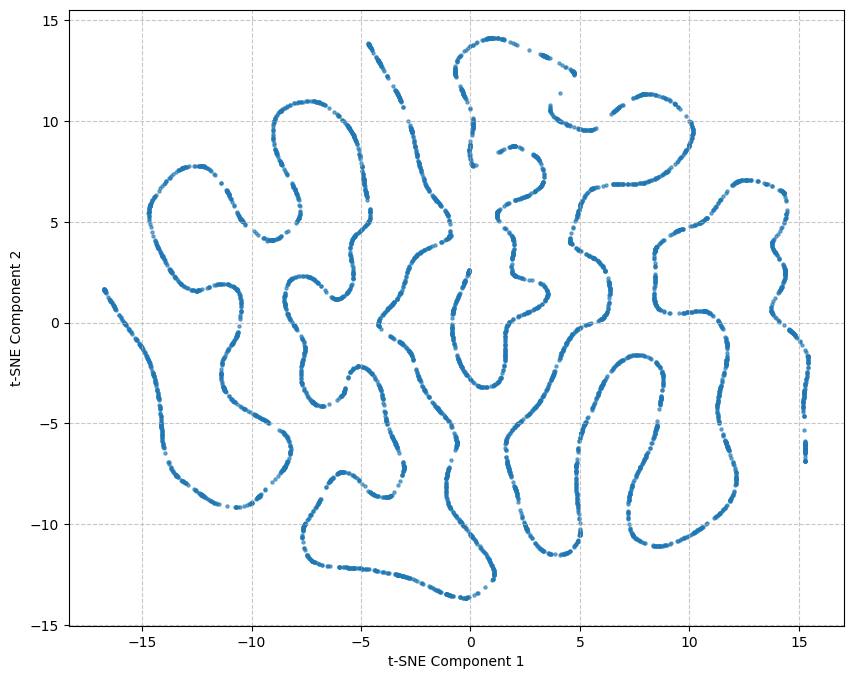

In [ ]:
num_samples_for_tsne = min(5000, len(final_embeddings_np)) 
print(f"\nPerforming t-SNE on {num_samples_for_tsne} samples...")
sample_indices = np.random.choice(len(final_embeddings_np), size=num_samples_for_tsne, replace=False)
tsne_embeddings = TSNE(n_components=2, perplexity=30, max_iter=300, init='pca', learning_rate='auto', random_state=42).fit_transform(final_embeddings_np[sample_indices])

plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=5, alpha=0.6)
# plt.title(f't-SNE of VAE-DTW Latent Space (Mu Embeddings) - {num_samples_for_tsne} samples')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## b) Silhouette Score using KMeans as a proxy for clustering quality

In [ ]:
# The number of clusters (n_clusters_kmeans) is a hyperparameter here.
n_clusters_kmeans = 70 
num_samples_for_silhouette = min(50000, len(final_embeddings_np)) 

if len(final_embeddings_np) >= n_clusters_kmeans and len(final_embeddings_np) > 1: 
    print(f"\nCalculating Silhouette Score using MiniBatchKMeans (k={n_clusters_kmeans}) on {num_samples_for_silhouette} samples...")
    if num_samples_for_silhouette < len(final_embeddings_np):
        sample_indices_silhouette = np.random.choice(len(final_embeddings_np), size=num_samples_for_silhouette, replace=False)
        embeddings_for_silhouette = final_embeddings_np[sample_indices_silhouette]
    else:
        embeddings_for_silhouette = final_embeddings_np

    try:
        kmeans = MiniBatchKMeans(n_clusters=n_clusters_kmeans, batch_size=max(256, BATCH_SIZE*2), n_init='auto', random_state=42).fit(embeddings_for_silhouette)
        labels_kmeans = kmeans.labels_
        if len(np.unique(labels_kmeans)) > 1: 
            silhouette_avg = silhouette_score(embeddings_for_silhouette, labels_kmeans)
            print(f"Silhouette Score (k={n_clusters_kmeans}, {num_samples_for_silhouette} samples): {silhouette_avg:.4f}")
        else:
            print(f"KMeans produced only {len(np.unique(labels_kmeans))} cluster(s). Cannot calculate Silhouette Score.")
    except Exception as e:
        print(f"Error: {e}")
else:
    print(f"Skipping Silhouette Score calculation.")



Calculating Silhouette Score using MiniBatchKMeans (k=70) on 50000 samples...
Silhouette Score (k=70, 50000 samples): 0.5411


# End